In [1]:
%%bash
# Do not change or modify this file
# Need to install pyspark
# if pyspark is already installed, will print a message indicating pyspark already isntalled
pip install pyspark

# Download the data files from github
# If the data file does not exist in the colab environment
if [[ ! -f ./data.csv ]]; then 
   # download the data file from github and save it in this colab environment instance
   wget  https://raw.githubusercontent.com/ssadagop97/IST718-Fall2020/main/data.csv
fi
ls data.csv

data.csv


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import lower, col
spark = SparkSession .builder.master("local[*]").config("spark.memory.fraction", 0.8) .config("spark.executor.memory", "12g").config("spark.driver.memory", "12g").config("spark.memory.offHeap.enabled",'true').config("spark.memory.offHeap.size","12g").getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [3]:
import numpy as np
import pandas as pd
from pyspark.ml import feature
from pyspark.ml import classification
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import functions as fn
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, \
    MulticlassClassificationEvaluator, \
    RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.regression import LinearRegression
import seaborn as sns

In [4]:
tracks_df = spark.read.format("csv").option("header", "true").load("data.csv")
tracks_df.dtypes

[('track_id', 'string'),
 ('Album Title', 'string'),
 ('Album_ID', 'string'),
 ('Artist_ID', 'string'),
 ('title', 'string'),
 ('Number of tracks', 'string'),
 ('type', 'string'),
 ('Album Created Date', 'string'),
 ('Year', 'string'),
 ('associated_labels', 'string'),
 ('Albums Listen', 'string'),
 ('album_favourites', 'string'),
 ('track_favorites', 'string'),
 ('tags', 'string'),
 ('composer', 'string'),
 ('duration', 'string'),
 ('genre_id', 'string'),
 ('top_genre', 'string'),
 ('genre_top', 'string'),
 ('interest', 'string'),
 ('language_code', 'string'),
 ('Song listens', 'string'),
 ('chroma_cens', 'string'),
 ('chroma_cqt', 'string'),
 ('chroma_stft', 'string'),
 ('mfcc', 'string'),
 ('rmse', 'string'),
 ('spectral_bandwidth', 'string'),
 ('spectral_centroid', 'string'),
 ('spectral_contrast', 'string'),
 ('spectral_rolloff', 'string'),
 ('tonnetz', 'string'),
 ('zcr', 'string'),
 ('top_genres', 'string')]

In [5]:


from pyspark.sql.types import DoubleType
from pyspark.sql.types import DateType

tracks_df = tracks_df.withColumn("num_tracks_in_album", tracks_df["Number of tracks"].cast(DoubleType()))
tracks_df = tracks_df.withColumn("year_of_release", tracks_df["Year"].cast(DateType()))
tracks_df = tracks_df.withColumn("num_listens_per_album", tracks_df["Albums Listen"].cast(DoubleType()))
tracks_df = tracks_df.withColumn("track_favorites", tracks_df["track_favorites"].cast(DoubleType()))
tracks_df = tracks_df.withColumn("album_favourites", tracks_df["album_favourites"].cast(DoubleType()))
tracks_df = tracks_df.withColumn("duration", tracks_df["duration"].cast(DoubleType()))
tracks_df = tracks_df.withColumn("interest", tracks_df["interest"].cast(DoubleType()))
tracks_df = tracks_df.withColumn("num_listens_per_song", tracks_df["Song listens"].cast(DoubleType()))
tracks_df = tracks_df.withColumn("chroma_cens", tracks_df["chroma_cens"].cast(DoubleType()))
tracks_df = tracks_df.withColumn("chroma_cqt", tracks_df["chroma_cqt"].cast(DoubleType()))
tracks_df = tracks_df.withColumn("chroma_stft", tracks_df["chroma_stft"].cast(DoubleType()))
tracks_df = tracks_df.withColumn("mfcc", tracks_df["mfcc"].cast(DoubleType()))
tracks_df = tracks_df.withColumn("rmse", tracks_df["rmse"].cast(DoubleType()))
tracks_df = tracks_df.withColumn("spectral_centroid", tracks_df["spectral_centroid"].cast(DoubleType()))
tracks_df = tracks_df.withColumn("spectral_bandwidth", tracks_df["spectral_bandwidth"].cast(DoubleType()))
tracks_df = tracks_df.withColumn("spectral_contrast", tracks_df["spectral_contrast"].cast(DoubleType()))
tracks_df = tracks_df.withColumn("spectral_rolloff", tracks_df["spectral_rolloff"].cast(DoubleType()))
tracks_df = tracks_df.withColumn("tonnetz", tracks_df["tonnetz"].cast(DoubleType()))
tracks_df = tracks_df.withColumn("zcr", tracks_df["zcr"].cast(DoubleType()))

In [6]:
cont_columns=['num_tracks_in_album','year_of_release','num_listens_per_album','track_favorites','album_favourites','duration','interest','num_listens_per_song','chroma_cens','chroma_cqt','chroma_stft','mfcc','rmse',
             'spectral_centroid','spectral_bandwidth','spectral_contrast','spectral_rolloff','tonnetz','zcr']
cat_columns = ['track_id','Album Title','Album_ID','Artist_ID','title','type','associated_labels','tags','composer','top_genres','language_code','genre_top']
tracks_df = tracks_df.select('track_id','Album Title','Album_ID','Artist_ID','title','type','associated_labels','tags','composer','top_genres','genre_top','language_code','num_tracks_in_album','year_of_release','num_listens_per_album','track_favorites','album_favourites','duration','interest','num_listens_per_song','chroma_cens','chroma_cqt','chroma_stft','mfcc','rmse','spectral_centroid','spectral_bandwidth','spectral_contrast','spectral_rolloff','tonnetz','zcr')

In [7]:
tracks_df.dtypes

[('track_id', 'string'),
 ('Album Title', 'string'),
 ('Album_ID', 'string'),
 ('Artist_ID', 'string'),
 ('title', 'string'),
 ('type', 'string'),
 ('associated_labels', 'string'),
 ('tags', 'string'),
 ('composer', 'string'),
 ('top_genres', 'string'),
 ('genre_top', 'string'),
 ('language_code', 'string'),
 ('num_tracks_in_album', 'double'),
 ('year_of_release', 'date'),
 ('num_listens_per_album', 'double'),
 ('track_favorites', 'double'),
 ('album_favourites', 'double'),
 ('duration', 'double'),
 ('interest', 'double'),
 ('num_listens_per_song', 'double'),
 ('chroma_cens', 'double'),
 ('chroma_cqt', 'double'),
 ('chroma_stft', 'double'),
 ('mfcc', 'double'),
 ('rmse', 'double'),
 ('spectral_centroid', 'double'),
 ('spectral_bandwidth', 'double'),
 ('spectral_contrast', 'double'),
 ('spectral_rolloff', 'double'),
 ('tonnetz', 'double'),
 ('zcr', 'double')]

In [8]:
from pyspark.sql import functions as fn
from pyspark.sql.functions import col
top_gernes=['Electronic',
'Avant-Garde',
'Experimental',
'Rock',
'Pop',
'Folk',
'Hip-Hop',
'Punk',
'Noise',
'Soundtrack',
'Lo-Fi',
'Experimental Pop',
'Jazz',
'Classical',
'International',
'Blues',
'Ambient Electronic',
'Indie-Rock',
'Field Recordings',
'Psych-Rock'
]
tracks_df = tracks_df.withColumn("top_genres",fn.when(col("top_genres").isin(top_gernes), col("top_genres")).otherwise(col("genre_top")))
tracks_df = tracks_df.withColumn("top_genres",fn.when(col("top_genres").isin(top_gernes), col("top_genres")).otherwise('Others'))

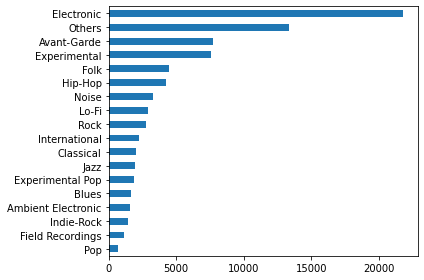

Text(0.5, 1.0, 'Y Var: Distribution')

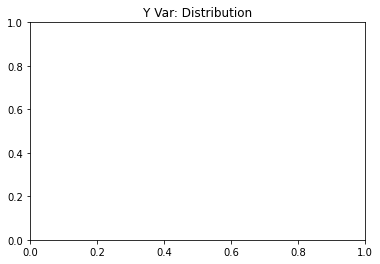

In [9]:
#Y Variable Distribution
import matplotlib.pyplot as plt
i = 0
for var_name in ['top_genres']:
    tracks_df.toPandas()[var_name].value_counts().sort_values().plot(kind = 'barh', color = 'C0')
plt.tight_layout()
plt.show()
plt.title('Y Var: Distribution')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


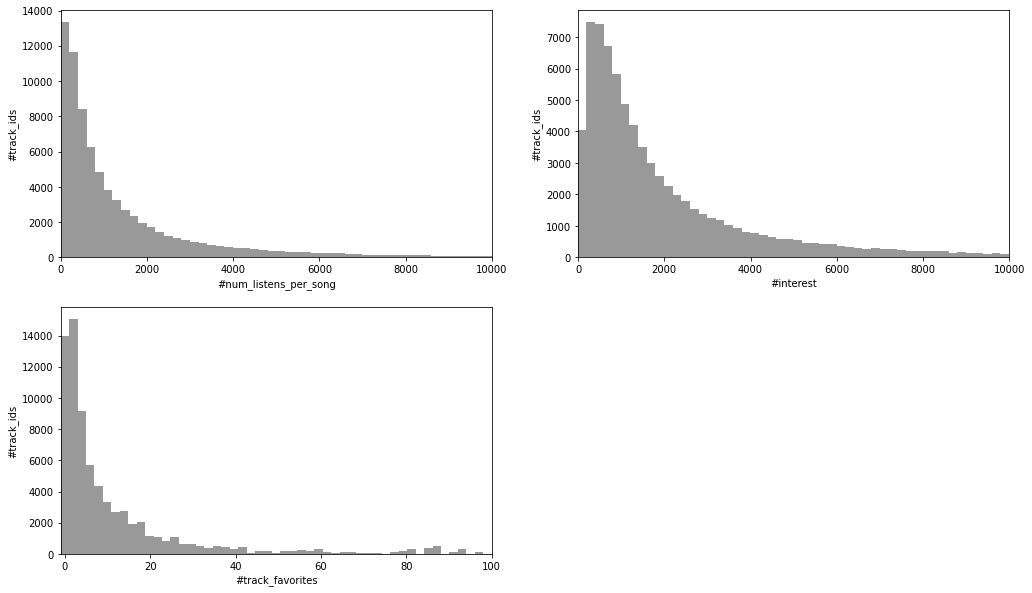

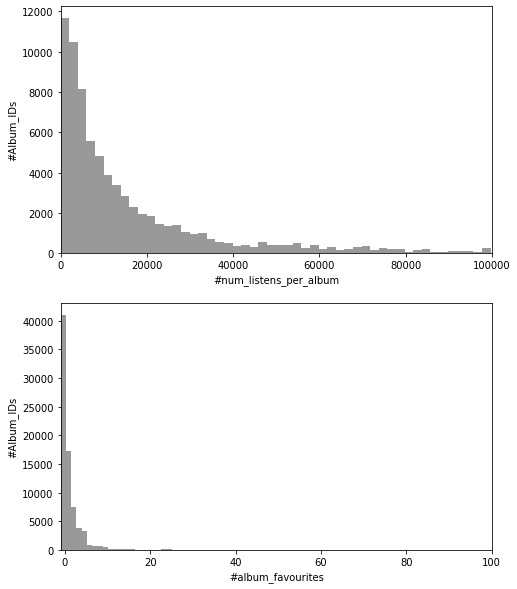

In [10]:
# Listens, favorites, comments.

def plot(col0, col1, maxval, subplot=None):
    if col0 == 'track_id':
        d = tracks_df.select('track_id',col1).toPandas()
    if col0 in ['Album_ID']:
        d = tracks_df.select(col0,col1).toPandas()
    if subplot:
        plt.subplot(subplot)
    d = d[col1]
    p = sns.distplot(d[d.values < maxval], kde=False, color='k', hist_kws=dict(alpha=0.4))
    p.set_xlim(-1, maxval)
    p.set_xlabel('#' + col1)
    p.set_ylabel('#' + col0 + 's')

plt.figure(figsize=(17, 10))
plot('track_id', 'num_listens_per_song', 10e3, 221)
plot('track_id', 'interest', 10e3, 222)
plot('track_id', 'track_favorites', 100, 223)

plt.figure(figsize=(17, 10))
plot('Album_ID', 'num_listens_per_album', 100e3, 221)
plot('Album_ID', 'album_favourites', 100, 223)


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


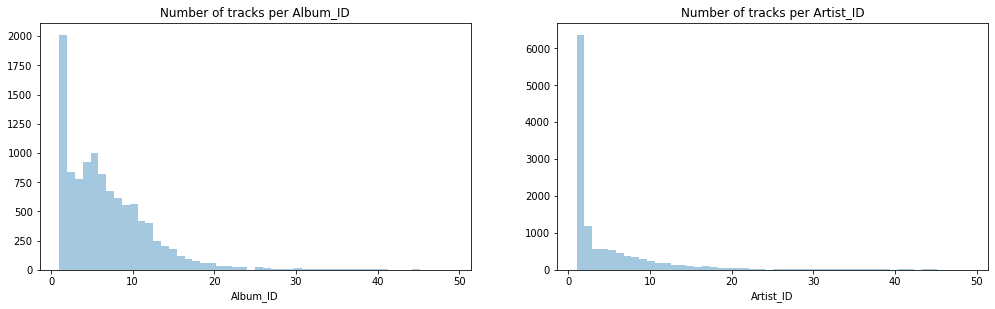

In [11]:
def plo_per_trackt(col0,subplot=None):
    if subplot:
        plt.subplot(subplot)
    for effect in [col0]:
        d = tracks_df.select(effect).toPandas()[effect].value_counts()
        p = sns.distplot(d[(d.values < 50) & (d.values >= 0)], kde=False).set_title('Number of tracks per '+effect)

plt.figure(figsize=(17, 10))

plo_per_trackt('Album_ID', 221)
plo_per_trackt('Artist_ID', 222)

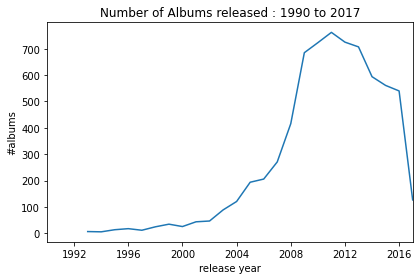

In [12]:
from pandas import Grouper
from matplotlib import pyplot
import datetime

def plot(col0, col1):
    if col0 == 'track_id':
        d = tracks_df.select('track_id',col1).toPandas().drop_duplicates('track_id')
    if col0 in ['Album_ID']:
        d = tracks_df.select(col0,col1).toPandas().drop_duplicates('Album_ID')
    d=d.groupby([col1]).count().reset_index()
    p=sns.lineplot(data=d[30:], x="year_of_release", y="Album_ID")
    p.set_xlim(pd.to_datetime(1990, format='%Y'),pd.to_datetime(2017, format='%Y'))
plt.xlabel('release year')
plt.ylabel('#albums')
plt.title('Number of Albums released : 1990 to 2017')

plt.tight_layout()
plot('Album_ID', 'year_of_release')




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


,duration
count,78057.000000
mean,278.465239
std,307.875196
min,-1.830000
25%,146.000000
50%,218.000000
75%,312.000000
max,18350.000000


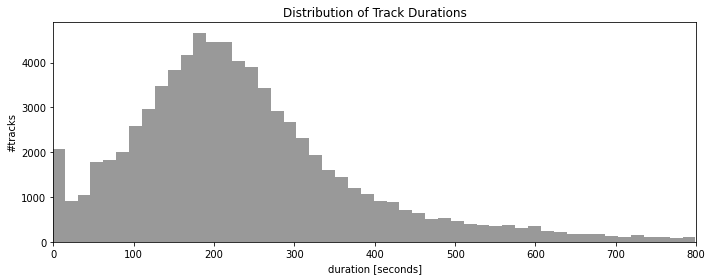

In [13]:
durations = tracks_df.select('track_id', 'duration').toPandas()
plt.figure(figsize=(10, 4))  # Poster: (7, 3)
d = durations['duration']
p = sns.distplot(d[d.values < 800], kde=False, rug=False, color='k', hist_kws=dict(alpha=0.4))
p.set_title('Distribution of Track Durations')
p.set_xlabel('duration [seconds]')
p.set_ylabel('#tracks')
p.set_xlim(0, 800)  # Poster: 500
plt.tight_layout()
durations.describe()

In [14]:
tracks_df.toPandas().to_csv('finaldf.csv')
tracks_df = spark.read.format("csv").option("header", "true").load("finaldf.csv")

In [15]:
from pyspark.sql.types import DoubleType
from pyspark.sql.types import DateType

tracks_df = tracks_df.withColumn("num_tracks_in_album", tracks_df["num_tracks_in_album"].cast(DoubleType()))
tracks_df = tracks_df.withColumn("year_of_release", tracks_df["year_of_release"].cast(DateType()))
tracks_df = tracks_df.withColumn("num_listens_per_album", tracks_df["num_listens_per_album"].cast(DoubleType()))
tracks_df = tracks_df.withColumn("track_favorites", tracks_df["track_favorites"].cast(DoubleType()))
tracks_df = tracks_df.withColumn("album_favourites", tracks_df["album_favourites"].cast(DoubleType()))
tracks_df = tracks_df.withColumn("duration", tracks_df["duration"].cast(DoubleType()))
tracks_df = tracks_df.withColumn("interest", tracks_df["interest"].cast(DoubleType()))
tracks_df = tracks_df.withColumn("num_listens_per_song", tracks_df["num_listens_per_song"].cast(DoubleType()))
tracks_df = tracks_df.withColumn("chroma_cens", tracks_df["chroma_cens"].cast(DoubleType()))
tracks_df = tracks_df.withColumn("chroma_cqt", tracks_df["chroma_cqt"].cast(DoubleType()))
tracks_df = tracks_df.withColumn("chroma_stft", tracks_df["chroma_stft"].cast(DoubleType()))
tracks_df = tracks_df.withColumn("mfcc", tracks_df["mfcc"].cast(DoubleType()))
tracks_df = tracks_df.withColumn("rmse", tracks_df["rmse"].cast(DoubleType()))
tracks_df = tracks_df.withColumn("spectral_centroid", tracks_df["spectral_centroid"].cast(DoubleType()))
tracks_df = tracks_df.withColumn("spectral_bandwidth", tracks_df["spectral_bandwidth"].cast(DoubleType()))
tracks_df = tracks_df.withColumn("spectral_contrast", tracks_df["spectral_contrast"].cast(DoubleType()))
tracks_df = tracks_df.withColumn("spectral_rolloff", tracks_df["spectral_rolloff"].cast(DoubleType()))
tracks_df = tracks_df.withColumn("tonnetz", tracks_df["tonnetz"].cast(DoubleType()))
tracks_df = tracks_df.withColumn("zcr", tracks_df["zcr"].cast(DoubleType()))

In [16]:
features = list(tracks_df.columns)
features

['_c0',
 'track_id',
 'Album Title',
 'Album_ID',
 'Artist_ID',
 'title',
 'type',
 'associated_labels',
 'tags',
 'composer',
 'top_genres',
 'genre_top',
 'language_code',
 'num_tracks_in_album',
 'year_of_release',
 'num_listens_per_album',
 'track_favorites',
 'album_favourites',
 'duration',
 'interest',
 'num_listens_per_song',
 'chroma_cens',
 'chroma_cqt',
 'chroma_stft',
 'mfcc',
 'rmse',
 'spectral_centroid',
 'spectral_bandwidth',
 'spectral_contrast',
 'spectral_rolloff',
 'tonnetz',
 'zcr']

In [17]:
features.remove('_c0')
features.remove('track_id')
features.remove('Album Title')
features.remove('Album_ID')
features.remove('Artist_ID')
features.remove('tags')
features.remove('composer')
features.remove('genre_top')
features.remove('title')
features.remove('associated_labels')
features.remove('type')

In [18]:
#This function will generate an Excel file call 'univariate_test' in the path specified aboy at 'path'


def univariate(train):

        '''

            this function is for univariate analysis,

        '''

        #if 

        x = [x for x in train.columns if train[x].dtypes != 'object']

        data = train[x]

        #y = data.describe()

#         evcount = target.value_counts()

#         evratio = evcount[event]/target.count()

        def Range(y):

            mi = np.min(y)

            ma = np.max(y)

            rng = ma-mi

            return rng

        Rnge = data.apply(Range)

        def iqr(y):

            x25 = np.percentile(y,25)

            x75 = np.percentile(y,75)

            Iqr = x75 - x25

            return Iqr

           

        iQr = data.apply(iqr)

        def Skew(y):

            d = skew(y)

            return d

        skewness = data.apply(Skew)

        def Kurt(y):

            d = kurtosis(y)

            return d

        Kurtosis = data.apply(Kurt)

       

        mean = data.apply(np.mean)

        stdv = data.apply(np.std)

        median = data.apply(np.median)

        missingno = data.isnull().sum()

        def outlier(y):

            q1 = np.percentile(y,25)

            q3 = np.percentile(y,75)

            iqr = q3-q1

            outlier = ((y > (q3 +1.5*iqr)) |(y <(q1-1.5*iqr ))).sum()

            return outlier

        Q1 = data.quantile(.25) 
        
        p1=data.quantile(0.01)
        p3=data.quantile(0.99)

        Q3 = data.quantile(.75)

        out = data.apply(outlier)
         
        count=train.shape[0]
        
        missingper=(missingno/count)*100

        Frame = [Rnge,Q1,Q3,p1,p3,iQr,skewness,Kurtosis,mean,stdv,median,missingno,out,missingper]

        unistat = pd.concat(Frame,axis =1)
        
        unistat.columns = ['Range','Q1','Q3','p1','p99','IQR','Skewness','Kurtosis','mean','stdv','median','MissingValue','outlier','Missing_perc']

        l=[]
        
        for i in missingper:
            if i>99:
                l.append(1)
            else:
                l.append(0)
                
        unistat['Missing_Criteria']=l
        
        unistat=unistat[['MissingValue','Missing_perc','mean','median','stdv','p1','p99','Range','Q1','Q3','IQR','outlier','Skewness','Kurtosis']]
        z = [x for x in train.columns if train[x].dtypes == 'object']

        dat = train[z]

        cat = {}

        for i in z:

            cat[i]= dat[i].value_counts()
        
        data={'catdist':cat , 'unistat':unistat}
        k=0

        engine = 'xlsxwriter'

        writer = pd.ExcelWriter('univariates_test.xlsx',engine=engine)

        uni=data['unistat']

        k=len(uni)+1

        uni.to_excel(writer,sheet_name='univariates',startrow=0,startcol=0,index=True)

        for i in data['catdist']:
            sum1=train.shape[0]
            report_df = pd.DataFrame()
            print(data['catdist'][i].index)
            report_df[i] = list(data['catdist'][i].index)
            report_df["Numbers"] = data['catdist'][i].values
            l1=[]
            for j in data['catdist'][i]:
                l1.append(j/sum1)
            report_df["perc"] = l1
#              print('reprt_df is')
#              print(report_df)
            report_df.to_excel(writer,sheet_name='univariates',startrow=k+1,startcol=0,index=True)

            k=len(data['catdist'][i])+2+k

        writer.close()

In [19]:
!pip install xlsxwriter

In [20]:
import pickle
import pandas as pd
import numpy as np
from scipy.stats import kurtosis
from scipy import stats
from scipy.stats import skew
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
import json
from scipy.stats import mstats
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
univariate(tracks_df.select(features).toPandas())
print('\nPls View the Excel Sheet for the Univariates')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Index(['Electronic', 'Others', 'Avant-Garde', 'Experimental', 'Folk',
       'Hip-Hop', 'Noise', 'Lo-Fi', 'Rock', 'International', 'Classical',
       'Jazz', 'Experimental Pop', 'Blues', 'Ambient Electronic', 'Indie-Rock',
       'Field Recordings', 'Pop', ' 'the allentown ocean good times band'',
       ' 'electronica']""', ' 'dub']""', '['ariel pinks haunted graffiti']',
       ' 'curtains'', 'Garage', '600', '['nathan eckel']', '404', '366',
       '['dubstep', 'trip-hop', 'trap', 'electronica', 'downtempo', 'nihilore']',
       '778', '15', '150', '293', '['jonathan biss']', '362', '224',
       'Beethoven', '84', '448', '416', '94', '274', '480',
       '['intrahealth international']', '626', '330', '312', '481',
       '['sagan']', '360', '624', '1855', '492'],
      dtype='object')
Index(['en', ' 'classwar karaoke'', 'fr', 'es', 'pt', 'de', 'it', '6', 'ru',
       'tr',
       ...
       '1.11E-01', '2.66E+01', '1.86E+01', '1.21E+03', '2.20E+01', '1.51E+01',
       '2.89E+03', 